In [116]:
import numpy as np
import os
import matplotlib.pyplot as plt

def read_event_file(file_path):
    with open(file_path, 'rb') as f:
        raw_data = np.fromfile(f, dtype=np.uint8)
    
    events = raw_data.reshape(-1, 5)
    
    x = events[:, 0].astype(np.uint16)
    y = events[:, 1].astype(np.uint16)
    polarity = events[:, 2] & 0x01
    timestamp = (events[:, 2] & 0xfe) << 16 | events[:, 3] << 8 | events[:, 4]
    
    return np.column_stack((timestamp, x, y, polarity))

# Read a single sequence
dataset_path = '../../datasets/N-Caltech101/Caltech101'
class_name = 'airplanes'  # Choose a class
file_name = 'image_0001.bin'  # Choose a specific file
file_path = os.path.join(dataset_path, class_name, file_name)
events = read_event_file(file_path)

In [117]:
print(events[34930])

[155 186  76   1]


In [118]:
def create_time_surface(events, sensor_size=(180, 240), tau=1000):
    last_spike = np.zeros(sensor_size)
    time_surface = np.zeros(sensor_size)
    
    for t, x, y, p in events:
        last_spike[y, x] = t
        time_surface = np.exp((last_spike - t) / tau)
    
    return time_surface

# Generate time surface map
sensor_size = (180, 240)  # Adjust based on your dataset
tau = 1000  # Time constant, adjust as needed
time_surface = create_time_surface(events, sensor_size, tau)

KeyboardInterrupt: 

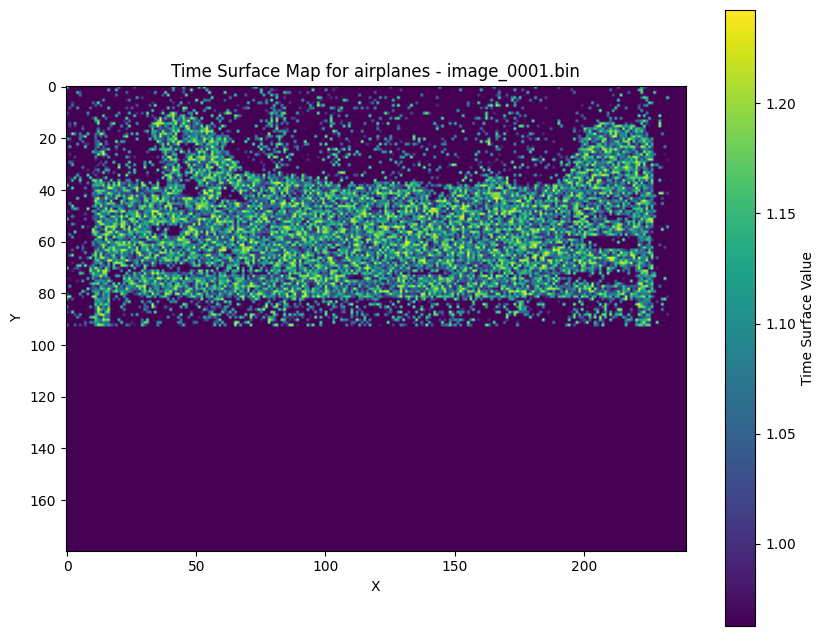

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(time_surface, cmap='viridis')
plt.colorbar(label='Time Surface Value')
plt.title(f'Time Surface Map for {class_name} - {file_name}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [56]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def read_event_file(file_path):
    with open(file_path, 'rb') as f:
        raw_data = np.fromfile(f, dtype=np.uint8)
    
    events = raw_data.reshape(-1, 5)
    
    x = events[:, 0].astype(np.uint16)
    y = events[:, 1].astype(np.uint16)
    polarity = events[:, 2] & 0x01
    timestamp = (events[:, 2] & 0xfe) << 16 | events[:, 3] << 8 | events[:, 4]
    
    return np.column_stack((timestamp, x, y, polarity))

def create_time_surface(events, sensor_size=(180, 240), tau=1000):
    last_spike = np.zeros(sensor_size)
    time_surface = np.zeros(sensor_size)
    
    for t, x, y, p in events:
        last_spike[y, x] = t
        time_surface = np.exp((last_spike - t) / tau)
    
    return time_surface

# Set up the path to the airplanes folder
dataset_path = '../../datasets/N-Caltech101/Caltech101'
airplanes_folder = os.path.join(dataset_path, 'airplanes')

# Set up the path for saving time surface images
save_folder = './time_surface_airplanes'

# Create the directory if it does not exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Get all .bin files in the airplanes folder
all_bin_files = [f for f in os.listdir(airplanes_folder) if f.endswith('.bin')]

# Sort the bin files to ensure consistent numbering
all_bin_files.sort()

# Select which bin numbers to process
print(f"Total number of .bin files: {len(all_bin_files)}")
bin_numbers = input("Enter the bin numbers to process (e.g., '1-5,7,10-12' or 'all'): ")

if bin_numbers.lower() == 'all':
    selected_files = all_bin_files
else:
    selected_indices = []
    for part in bin_numbers.split(','):
        if '-' in part:
            start, end = map(int, part.split('-'))
            selected_indices.extend(range(start-1, end))
        else:
            selected_indices.append(int(part)-1)
    selected_files = [all_bin_files[i] for i in selected_indices if i < len(all_bin_files)]

print(f"Processing {len(selected_files)} files")

# Process selected .bin files with a progress bar
for file_name in tqdm(selected_files, desc="Processing files"):
    file_path = os.path.join(airplanes_folder, file_name)
    events = read_event_file(file_path)
    
    # Generate time surface map
    sensor_size = (180, 240)
    tau = 1000
    time_surface = create_time_surface(events, sensor_size, tau)
    
    # Save the time surface map as an image
    save_path = os.path.join(save_folder, f'{os.path.splitext(file_name)[0]}_time_surface.png')
    plt.figure(figsize=(8, 6))
    plt.imshow(time_surface, cmap='viridis')
    # plt.colorbar(label='Time Surface Value')
    plt.title(f'Time Surface Map for {file_name}')
    plt.axis('off')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

print(f"All selected time surface images have been saved to {save_folder}")

Total number of .bin files: 800
Processing 1 files


Processing files: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]

All selected time surface images have been saved to ./time_surface_airplanes


In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Paths
dataset_path = '../../datasets/N-Caltech101/Caltech101'
annotations_path = '../../datasets/N-Caltech101/Caltech101_annotations'
save_folder = './visualized_events'

# Create save folder if it doesn't exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

def read_event_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            raw_data = np.fromfile(f, dtype=np.uint8)
        events = raw_data.reshape(-1, 5)
        x = events[:, 0].astype(np.uint16)
        y = events[:, 1].astype(np.uint16)
        polarity = events[:, 2] & 0x01
        timestamp = (events[:, 2] & 0xfe) << 16 | events[:, 3] << 8 | events[:, 4]
        return np.column_stack((timestamp, x, y, polarity))
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def read_annotation(annotation_file):
    annotations = {}
    try:
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    file_id = parts[0]
                    # Assuming the format is: file_id x_min y_min width height
                    bbox = list(map(float, parts[1:5]))
                    annotations[file_id] = bbox
    except FileNotFoundError:
        print(f"Annotation file not found: {annotation_file}")
    return annotations

def visualize_events(events, bbox=None, title=''):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot events
    positive_events = events[events[:, 3] == 1]
    negative_events = events[events[:, 3] == 0]
    ax.scatter(positive_events[:, 1], positive_events[:, 2], c='blue', s=1, alpha=0.5, label='Positive events')
    ax.scatter(negative_events[:, 1], negative_events[:, 2], c='red', s=1, alpha=0.5, label='Negative events')
    
    # Add bounding box if provided
    if bbox is not None:
        x, y, w, h = bbox
        rect = Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
    
    ax.set_xlim(0, 240)
    ax.set_ylim(0, 180)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return fig

# Example usage
example_class = 'airplanes'
example_file = 'image_0001.bin'

# Read event data
file_path = os.path.join(dataset_path, example_class, example_file)
event_data = read_event_file(file_path)

if event_data is not None:
    # Read annotation
    annotation_file = os.path.join(annotations_path, f"{example_class}_annotations.txt")
    annotations = read_annotation(annotation_file)
    
    file_id = os.path.splitext(example_file)[0]
    bbox = annotations.get(file_id)
    
    # Visualize
    fig = visualize_events(event_data, bbox, f"{example_class}: {file_id}")
    
    # Save visualization
    save_path = os.path.join(save_folder, f'{example_class}_{file_id}.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Visualization saved to {save_path}")
else:
    print("Failed to read event data")

Annotation file not found: ../../datasets/N-Caltech101/Caltech101_annotations/airplanes_annotations.txt
Visualization saved to ./visualized_events/airplanes_image_0001.png


In [2]:
################ Initial setup ################
import os
import numpy as np

def read_dataset(filename):
    """Reads in the TD events contained in the N-MNIST/N-CALTECH101 dataset file specified by 'filename'"""
    f = open(filename, 'rb')
    raw_data = np.fromfile(f, dtype=np.uint8)
    f.close()
    raw_data = np.uint32(raw_data)

    all_y = raw_data[1::5]
    all_x = raw_data[0::5]
    all_p = (raw_data[2::5] & 128) >> 7 #bit 7
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])

    #Process time stamp overflow events
    time_increment = 2**13
    overflow_indices = np.where(all_y == 240)[0]
    for overflow_index in overflow_indices:
        all_ts[overflow_index:] += time_increment

    #Everything else is a proper td spike
    td_indices = np.where(all_y != 240)[0]

    return all_ts[td_indices], all_x[td_indices], all_y[td_indices], all_p[td_indices]

def read_ncaltech101(root_dir):
    """Reads the NCaltech101 dataset from the specified root directory"""
    data = []
    labels = []
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.bin'):
                    file_path = os.path.join(class_dir, filename)
                    ts, x, y, p = read_dataset(file_path)
                    data.append((ts, x, y, p))
                    labels.append(class_name)
    
    return data, labels

# Example usage
root_dir = '../../datasets/N-Caltech101/Caltech101'
data, labels = read_ncaltech101(root_dir)

print(f"Total number of samples: {len(data)}")
print(f"Number of classes: {len(set(labels))}")

# Example of accessing the first sample
first_sample = data[0]
print(f"First sample - Timestamps: {first_sample[0].shape}, X: {first_sample[1].shape}, Y: {first_sample[2].shape}, Polarity: {first_sample[3].shape}")
print(f"First sample label: {labels[0]}")

Total number of samples: 8709
Number of classes: 101
First sample - Timestamps: (262215,), X: (262215,), Y: (262215,), Polarity: (262215,)
First sample label: gerenuk


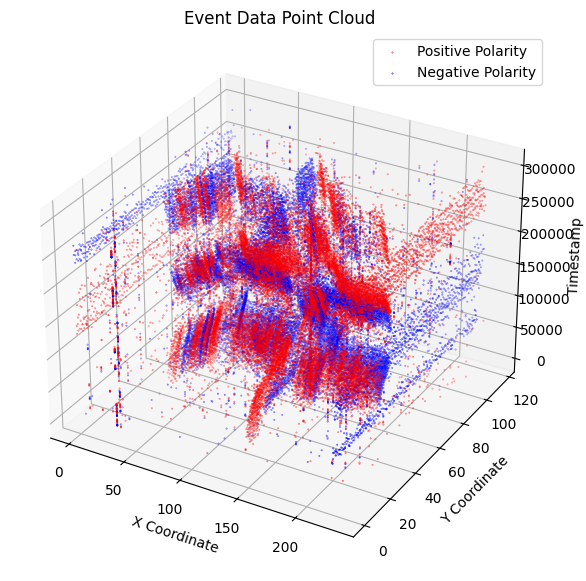

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_event_data(x, y, ts, p, point_size=0.1):
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot events with positive polarity in red
    ax.scatter(x[p == 1], y[p == 1], ts[p == 1], c='red', s=point_size, label='Positive Polarity')

    # Plot events with negative polarity in blue
    ax.scatter(x[p == 0], y[p == 0], ts[p == 0], c='blue', s=point_size, label='Negative Polarity')
    
    # Adding labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Timestamp')
    ax.set_title('Event Data Point Cloud')
    ax.legend()

    # Show plot
    plt.show()


# Example usage
file_path = '../../datasets/N-Caltech101/Caltech101/airplanes/image_0159.bin'
ts, x, y, p = read_dataset(file_path)
visualize_event_data(x, y, ts, p)



/var/folders/x9/7r6qb2md6xz907dnbvd0b8c40000gn/T/ipykernel_42160/3816017305.py:41: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Generated 76 frames


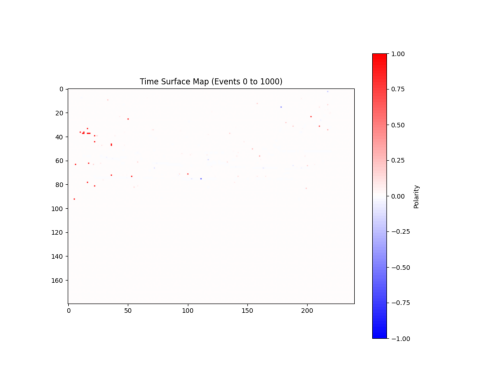

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_time_surface_map(x, y, ts, p, image_size=(180, 240), tau=1000, batch_size=1000):
    # Sort events by timestamp
    sort_indices = np.argsort(ts)
    x, y, ts, p = x[sort_indices], y[sort_indices], ts[sort_indices], p[sort_indices]

    # Create custom colormap (blue to white to red)
    colors = ['blue', 'white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    frames = []
    for start in range(0, len(ts), batch_size):
        end = start + batch_size
        batch_x, batch_y = x[start:end], y[start:end]
        batch_ts, batch_p = ts[start:end], p[start:end]

        # Create time surface
        time_surface = np.zeros(image_size)
        latest_timestamp = np.zeros(image_size)

        for xi, yi, t, pol in zip(batch_x, batch_y, batch_ts, batch_p):
            if 0 <= xi < image_size[1] and 0 <= yi < image_size[0]:
                time_surface[yi, xi] = (2 * pol - 1) * np.exp(-(t - latest_timestamp[yi, xi]) / tau)
                latest_timestamp[yi, xi] = t

        # Normalize time surface to [-1, 1] range
        time_surface = np.clip(time_surface, -1, 1)

        # Create frame
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(time_surface, cmap=cmap, vmin=-1, vmax=1)
        ax.set_title(f'Time Surface Map (Events {start} to {end})')
        plt.colorbar(im, ax=ax, label='Polarity')
        
        # Convert plot to image
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        
        plt.close(fig)

    return frames

# Example usage
file_path = '../../datasets/N-Caltech101/Caltech101/airplanes/image_0001.bin'
ts, x, y, p = read_dataset(file_path)

# Generate frames
frames = create_time_surface_map(x, y, ts, p)

print(f"Generated {len(frames)} frames")

# Display the first frame as an example
plt.imshow(frames[0])
plt.axis('off')
plt.show()

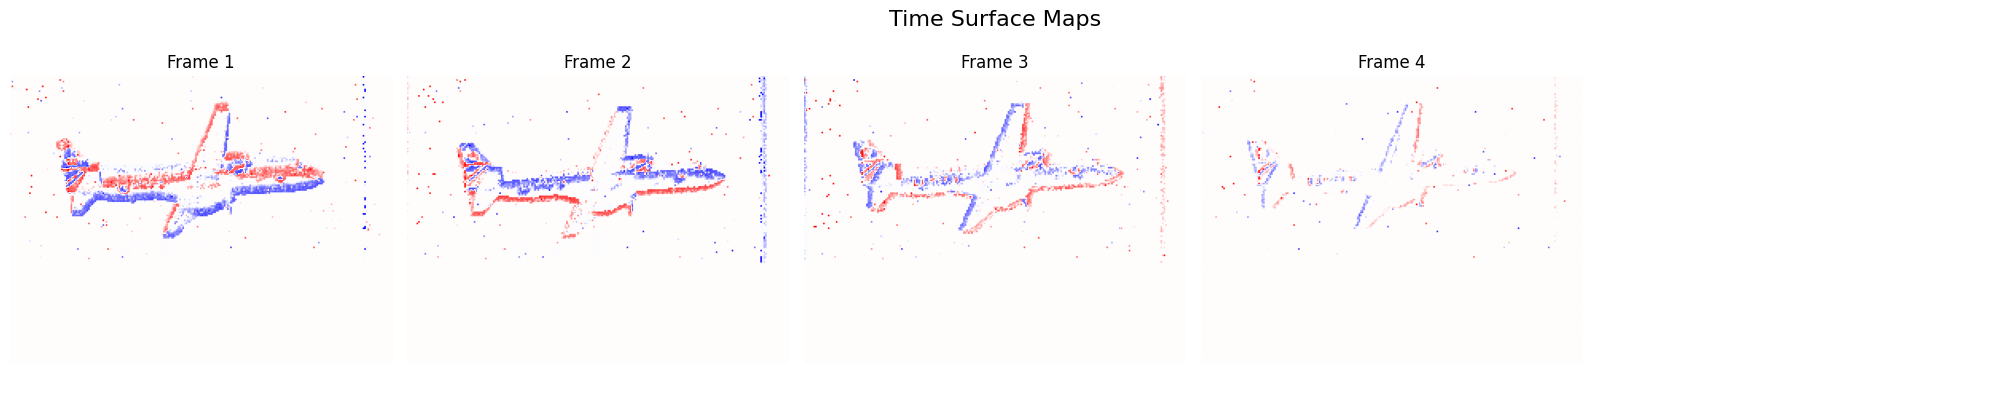

(180, 240)
Generated and displayed 4 frames


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math

def create_time_surface_map(x, y, ts, p, image_size=(180, 240), tau=6000, batch_size=15000):
    # Sort events by timestamp
    sort_indices = np.argsort(ts)
    x, y, ts, p = x[sort_indices], y[sort_indices], ts[sort_indices], p[sort_indices]

    # Create custom colormap (blue to white to red)
    colors = ['blue', 'white', 'red']
    n_bins = 255
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    frames = []
    for start in range(0, len(ts), batch_size):
        end = start + batch_size
        batch_x, batch_y = x[start:end], y[start:end]
        batch_ts, batch_p = ts[start:end], p[start:end]

        # Create time surface
        time_surface = np.zeros(image_size)
        latest_timestamp = np.zeros(image_size)

        for xi, yi, t, pol in zip(batch_x, batch_y, batch_ts, batch_p):
            if 0 <= xi < image_size[1] and 0 <= yi < image_size[0]:
                time_surface[yi, xi] = (2 * pol - 1) * np.exp(-(t - latest_timestamp[yi, xi]) / tau)
                latest_timestamp[yi, xi] = t

        # Normalize time surface to [-1, 1] range
        time_surface = np.clip(time_surface, -1, 1)
        frames.append(time_surface)

    return frames

# Example usage
file_path = '../../datasets/N-Caltech101/Caltech101/airplanes/image_0159.bin'
ts, x, y, p = read_dataset(file_path)

# Generate frames
frames = create_time_surface_map(x, y, ts, p)

# Display all frames
n_frames = len(frames)
n_cols = 5  # Number of columns in the grid
n_rows = math.ceil(n_frames / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
fig.suptitle('Time Surface Maps', fontsize=16)

# Create custom colormap (blue to white to red)
colors = ['blue', 'white', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

for i, ax in enumerate(axes.flat):
    if i < n_frames:
        im = ax.imshow(frames[i], cmap=cmap, vmin=-1, vmax=1)
        ax.set_title(f'Frame {i+1}')
    ax.axis('off')


plt.tight_layout()
plt.show()

print(frames[0].shape)

print(f"Generated and displayed {n_frames} frames")

4
2


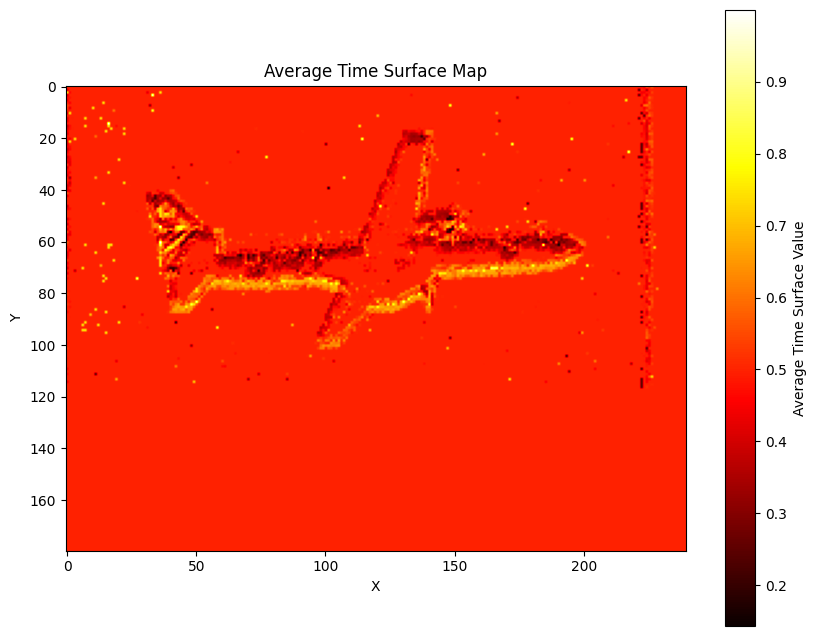

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
import cv2

def ransac_filter_time_surface_maps(time_surface_maps):
    """
    Use RANSAC to filter out outlier time surface maps based on event count.
    """
    # Count number of events (non-zero values) in each time surface map
    event_counts = np.array([np.count_nonzero(t_map) for t_map in time_surface_maps]).reshape(-1, 1)
    
    # Generate a linear model for RANSAC
    model = LinearRegression()
    ransac = RANSACRegressor(model, residual_threshold=0.1)
    
    # Fit the model
    ransac.fit(event_counts, np.arange(len(event_counts)))
    
    # Inlier mask
    inlier_mask = ransac.inlier_mask_
    
    # Return only the inlier time surface maps
    return [time_surface_maps[i] for i in range(len(time_surface_maps)) if inlier_mask[i]]

def average_time_surface_maps(time_surface_maps):
    """
    Average multiple time surface maps into a single map.
    """
    stacked_maps = np.stack(time_surface_maps)
    average_map = np.mean(stacked_maps, axis=0)
    return average_map

def convert_to_grayscale(frames):
    """
    Convert each time surface map in frames to grayscale.
    """
    grayscale_frames = []
    for frame in frames:
        # Convert the frame to float if it's not already
        frame_float = frame.astype(float)
        # Normalize the values to be between 0 and 1
        frame_normalized = (frame_float - frame_float.min()) / (frame_float.max() - frame_float.min())
        grayscale_frames.append(frame_normalized)
    return grayscale_frames


def visualize_average_map(average_map):
    """
    Visualize the average time surface map.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(average_map, cmap='hot')
    plt.colorbar(label='Average Time Surface Value')
    plt.title('Average Time Surface Map')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

frames_grayscale = convert_to_grayscale(frames)

# Example usage:
# Assuming you have a list of time surface maps from your mini-batches
time_surface_maps = frames_grayscale  # Your list of time surface maps goes here

print(len(time_surface_maps))

# Apply RANSAC filtering
filtered_maps = ransac_filter_time_surface_maps(time_surface_maps)
print(len(filtered_maps))
# Calculate the average map using the filtered maps
average_map = average_time_surface_maps(filtered_maps)

# Visualize the average map
visualize_average_map(average_map)

# gray_image = np.dot(average_map[..., :3], [0.299, 0.587, 0.114])

# plt.imshow(average_map)



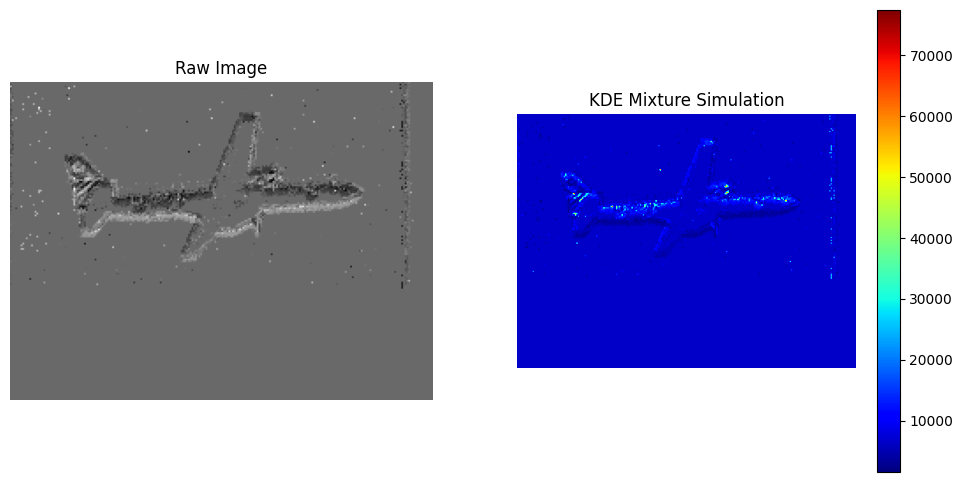

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Photometric KDE function
def photometric_kde(u_g, u, v, I_u, lambda_k):
    diff_u = u_g[0] - u
    diff_v = u_g[1] - v
    normalization = 1 / (2 * np.pi * (lambda_k * I_u)**2)
    return normalization * np.exp(-(diff_u**2 + diff_v**2) / (2 * (lambda_k * I_u)**2))

# KDE mixture function
def kde_mixture(u_g, image, lambda_k):
    u, v = np.indices(image.shape)
    I_u = image[u, v]
    mask = I_u > 0  # Ignore black pixels
    k_values = photometric_kde(u_g, u[mask], v[mask], I_u[mask], lambda_k)
    return np.sum(k_values)

# Function to simulate KDE mixture for the entire image
def simulate_kde_mixture(image, lambda_k):
    height, width = image.shape
    K_mixture = np.zeros((height, width))
    
    for u in range(height):
        for v in range(width):
            u_g = (u, v)
            K_mixture[u, v] = kde_mixture(u_g, image, lambda_k)
    
    return K_mixture

# Load and crop the image
# image_path = './test.png'
# image = Image.open(image_path).convert('L')

# average_map_grayscale = convert_to_grayscale(average_map)
# image = np.array(average_map_grayscale)

image = average_map



# Crop the image to the specified region
cropped_image = image[0:240, 0:320]

# Define lambda_k
lambda_k = 0.01  # Adjust this value as needed

# Simulate KDE mixture
result = simulate_kde_mixture(cropped_image, lambda_k)

# Visualize the cropped image and the result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cropped_image, cmap='gray')
ax[0].set_title('Raw Image')
ax[0].axis('off')

ax[1].imshow(result, cmap='jet')
ax[1].set_title('KDE Mixture Simulation')
ax[1].axis('off')

plt.colorbar(ax[1].imshow(result, cmap='jet'), ax=ax[1], orientation='vertical')
plt.show()

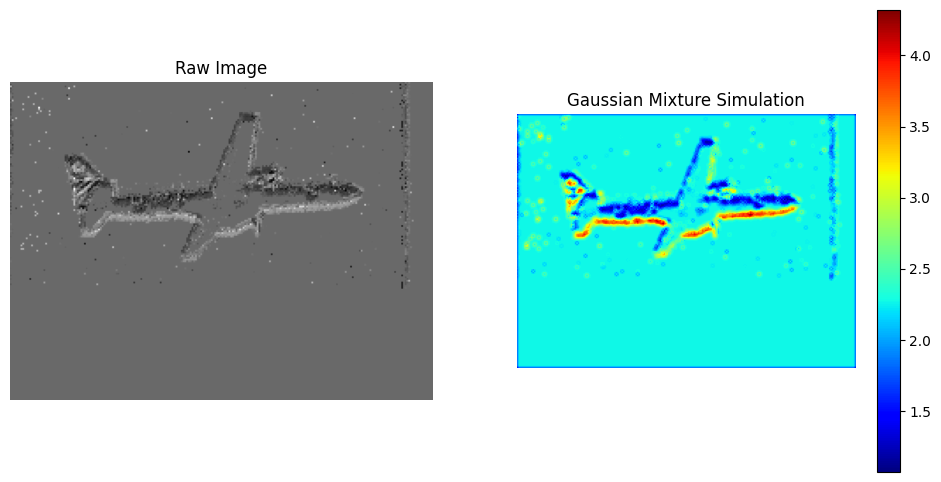

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Photometric Gaussian function
def photometric_gaussian(u_g, u, v, I_u, lambda_g):
    diff_u = u_g[0] - u
    diff_v = u_g[1] - v
    return np.exp(-(diff_u**2 + diff_v**2) / (2 * (lambda_g * I_u)**2))

# Gaussian mixture function
def gaussian_mixture(u_g, image, lambda_g):
    u, v = np.indices(image.shape)
    I_u = image[u, v]
    mask = I_u > 0  # Ignore black pixels
    g_values = photometric_gaussian(u_g, u[mask], v[mask], I_u[mask], lambda_g)
    return np.sum(g_values)

# Function to simulate Gaussian mixture for the entire image
def simulate_gaussian_mixture(image, lambda_g):
    height, width = image.shape
    G_mixture = np.zeros((height, width))
    
    for u in range(height):
        for v in range(width):
            u_g = (u, v)
            G_mixture[u, v] = gaussian_mixture(u_g, image, lambda_g)
    
    return G_mixture

# Load and crop the image

# image_path = './image_0001.jpg'
# image = Image.open(image_path).convert('L')
# image = np.array(image)

image = average_map
image = np.array(image)

# Crop the image to the specified region
cropped_image = image

# Define lambda_g
lambda_g = 1.2  # Adjust this value as needed

# Simulate Gaussian mixture
result = simulate_gaussian_mixture(cropped_image, lambda_g)

# Visualize the cropped image and the result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cropped_image, cmap='gray')
ax[0].set_title('Raw Image')
ax[0].axis('off')

ax[1].imshow(result, cmap='jet')
ax[1].set_title('Gaussian Mixture Simulation')
ax[1].axis('off')

plt.colorbar(ax[1].imshow(result, cmap='jet'), ax=ax[1], orientation='vertical')
plt.show()

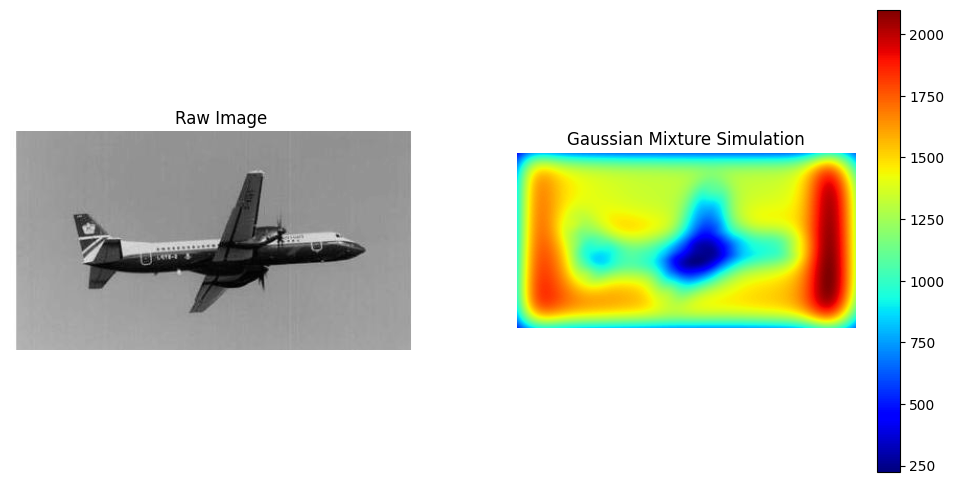

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Photometric Gaussian function
def photometric_gaussian(u_g, u, v, I_u, lambda_g):
    diff_u = u_g[0] - u
    diff_v = u_g[1] - v
    return np.exp(-(diff_u**2 + diff_v**2) / (2 * (lambda_g * I_u)**2))

# Gaussian mixture function
def gaussian_mixture(u_g, image, lambda_g):
    u, v = np.indices(image.shape)
    I_u = image[u, v]
    mask = I_u > 0  # Ignore black pixels
    g_values = photometric_gaussian(u_g, u[mask], v[mask], I_u[mask], lambda_g)
    return np.sum(g_values)

# Function to simulate Gaussian mixture for the entire image
def simulate_gaussian_mixture(image, lambda_g):
    height, width = image.shape
    G_mixture = np.zeros((height, width))
    
    for u in range(height):
        for v in range(width):
            u_g = (u, v)
            G_mixture[u, v] = gaussian_mixture(u_g, image, lambda_g)
    
    return G_mixture

# Load and crop the image

image_path = './image_0159.jpg'
image = Image.open(image_path).convert('L')
image = np.array(image)

# image = average_map
# image = np.array(image)

# Crop the image to the specified region
cropped_image = image

# Define lambda_g
lambda_g = 0.1  # Adjust this value as needed

# Simulate Gaussian mixture
result = simulate_gaussian_mixture(cropped_image, lambda_g)

# Visualize the cropped image and the result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cropped_image, cmap='gray')
ax[0].set_title('Raw Image')
ax[0].axis('off')

ax[1].imshow(result, cmap='jet')
ax[1].set_title('Gaussian Mixture Simulation')
ax[1].axis('off')

plt.colorbar(ax[1].imshow(result, cmap='jet'), ax=ax[1], orientation='vertical')
plt.show()

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Photometric Epanechnikov KDE function
def photometric_kde_epanechnikov(u_g, u, v, I_u, lambda_k):
    diff_u = u_g[0] - u
    diff_v = u_g[1] - v
    distance_squared = diff_u**2 + diff_v**2
    bandwidth_squared = (lambda_k * I_u)**2
    
    if distance_squared <= bandwidth_squared:
        return 0.75 * (1 - distance_squared / bandwidth_squared)
    else:
        return 0

# KDE mixture function
def kde_mixture_epanechnikov(u_g, image, lambda_k):
    u, v = np.indices(image.shape)
    I_u = image[u, v]
    mask = I_u > 0  # Ignore black pixels
    k_values = np.array([photometric_kde_epanechnikov(u_g, u_, v_, I_u_, lambda_k)
                         for u_, v_, I_u_ in zip(u[mask], v[mask], I_u[mask])])
    return np.sum(k_values)

# Function to simulate KDE mixture for the entire image
def simulate_kde_mixture_epanechnikov(image, lambda_k):
    height, width = image.shape
    K_mixture = np.zeros((height, width))
    
    for u in range(height):
        for v in range(width):
            u_g = (u, v)
            K_mixture[u, v] = kde_mixture_epanechnikov(u_g, image, lambda_k)
    
    return K_mixture

# Load and crop the image
# image_path = './test.png'
# image = Image.open(image_path).convert('L')
image = average_map
image = np.array(image)

# Crop the image to the specified region
cropped_image = image[0:240, 0:320]

# Define lambda_k
lambda_k = 0.1  # Adjust this value as needed

# Simulate KDE mixture
result = simulate_kde_mixture_epanechnikov(cropped_image, lambda_k)

# Visualize the cropped image and the result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cropped_image, cmap='gray')
ax[0].set_title('Cropped Image')
ax[0].axis('off')

ax[1].imshow(result, cmap='jet')
ax[1].set_title('KDE Mixture Simulation')
ax[1].axis('off')

plt.colorbar(ax[1].imshow(result, cmap='jet'), ax=ax[1], orientation='vertical')
plt.show()

KeyboardInterrupt: 